Run on NERSC

In [2]:
from __future__ import division, print_function
import sys, os, glob, time, warnings, gc
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, vstack, hstack
import fitsio
from astropy.io import fits
import healpy as hp
from astropy import wcs

import match_coord

In [2]:
params = {'legend.fontsize': 'large',
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large',
         'figure.facecolor':'w'} 
plt.rcParams.update(params)

In [3]:
from scipy.optimize import curve_fit

def get_frac_moffat(r, alpha, beta):
    """
    Calculate the fraction of light within radius r of a Moffat profile.
    """    
    frac = 1 - alpha**(2*(beta-1))*(alpha**2 + r**2)**(1-beta)
    return(frac)

def get_sb_moffat(r, alpha, beta):
    """
    Calculate the surface brightness of light at radius r of a Moffat profile.
    The integral (i.e., total flux) is unity by definition.
    """
    i = (beta-1)/(np.pi * alpha**2)*(1 + (r/alpha)**2)**(-beta)
    return i

def get_sb_moffat_plus_power_law(r, alpha1, beta1, plexp2, weight2):
    """
    Calculate the surface brightness of light at radius r of the sum of two Moffat profiles.
    The integral (i.e., total flux) is NOT unity.
    """
    i = (beta1-1)/(np.pi * alpha1**2)*(1 + (r/alpha1)**2)**(-beta1) \
        + weight2 *r**(plexp2)
    return i

def get_sb_double_moffat(r, alpha1, beta1, alpha2, beta2, weight2):
    """
    Calculate the surface brightness of light at radius r of the sum of two Moffat profiles.
    The integral (i.e., total flux) is NOT unity.
    """
    i = (beta1-1)/(np.pi * alpha1**2)*(1 + (r/alpha1)**2)**(-beta1) \
        + weight2 * (beta2-1)/(np.pi * alpha2**2)*(1 + (r/alpha2)**2)**(-beta2)
    return i

In [4]:
params = {
'g_weight2': 0.00045, 'g_plexp2': -2.,
'r_weight2': 0.00033, 'r_plexp2': -2.,
'z_alpha2': 17.650, 'z_beta2': 1.7, 'z_weight2': 0.0145,
}

outlier_ccd_list = ['N20', 'S8', 'S10', 'S18', 'S21', 'S27']
params_outlier = {'z_alpha2': 16, 'z_beta2': 2.3, 'z_weight2': 0.0095}

field = 'south'
region_name = 'decals_ngc'
pixscale = 0.262

vranges = {'g':0.08, 'r':0.012, 'z':0.03}

In [5]:
ccd_columns = ['image_filename', 'image_hdu', 'camera', 'expnum', 'ccdname', 'filter', 'fwhm', 'ra', 'dec', 'ccd_cuts', 'ccdzpt', 'exptime', 'ccdraoff', 'ccddecoff']
surveyccd_path = '/global/project/projectdirs/cosmo/work/legacysurvey/dr9/survey-ccds-decam-dr9-cut.fits.gz'

ccd = fitsio.read(surveyccd_path, columns=ccd_columns)
ccd = Table(ccd)

mask = ccd['ccd_cuts']==0
print(np.sum(mask)/len(mask))
ccd = ccd[mask]

# plt.figure(figsize=(10, 5))
# plt.plot(ccd['ra'][::10], ccd['dec'][::10], '.', ms=0.1)
# plt.show()

# gaia = Table.read('/global/homes/r/rongpu/notebooks/bright_star_profiles/data/gaia_sample_for_ccd_cutouts-decals_ngc.fits')

0.560138739773


In [6]:
# ra, dec = 0.0487, -0.3605
# gaia_g, gaia_bp, gaia_rp = 6.89, 7.53, 6.18
# print(gaia_bp-gaia_rp)

ra, dec = 148.12184029623234, 31.54267097002469
gaia_g, gaia_bp, gaia_rp = 7.46, 7.96, 6.84
print(gaia_bp-gaia_rp)

1.12


In [7]:
# Gaia-to-DECam transformations used in legacypipe
ls_mag = {}
color = gaia_bp - gaia_rp
bands = ['g', 'r', 'z']
for i,b in enumerate(bands):
    # Use Arjun's Gaia-to-DECam transformations.
    coeffs = dict(
        g=[-0.11368, 0.37504, 0.17344, -0.08107, 0.28088,
           -0.21250, 0.05773,-0.00525],
        r=[ 0.10533,-0.22975, 0.06257,-0.24142, 0.24441,
            -0.07248, 0.00676],
        z=[ 0.46744,-0.95143, 0.19729,-0.08810, 0.01566])[b]
    mag = gaia_g
    for order,c in enumerate(coeffs):
        mag += c * color**order
    ls_mag[b] = mag
print(ls_mag)

{'g': 8.039845639423591, 'r': 7.317512473171108, 'z': 7.0101861323776005}


In [8]:
# maximum RA, Dec separation for DECam CCDs
max_d_ra, max_d_dec = 4096*0.262/2, 2046*0.262/2
max_d_ra, max_d_dec = max_d_ra*0.95, max_d_dec*0.95 # trim CCD edges

idx1, idx2, d2d, d_ra, d_dec = match_coord.search_around([ra], [dec], ccd['ra'], ccd['dec'], search_radius=max(max_d_ra, max_d_dec))

mask = np.abs(d_ra)<max_d_ra
mask &= np.abs(d_dec)<max_d_dec
print(np.sum(mask))
# mask &= ccd['filter'][idx2]==band
# print(np.sum(mask))
idx1 = idx1[mask]
idx2 = idx2[mask]

ccd0 = ccd[idx2]
print(len(ccd0), 'CCD images available')

16 nearby objects
10
10 CCD images available


## Normalized to nanomaggie per pixel

535126
Exposure: 535126  CCD: S14


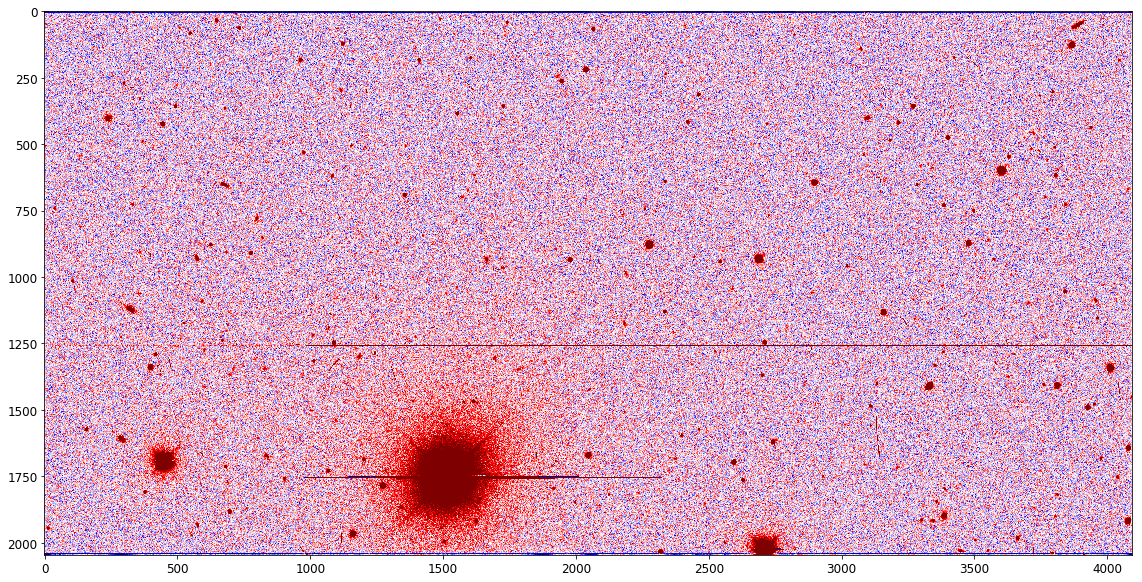

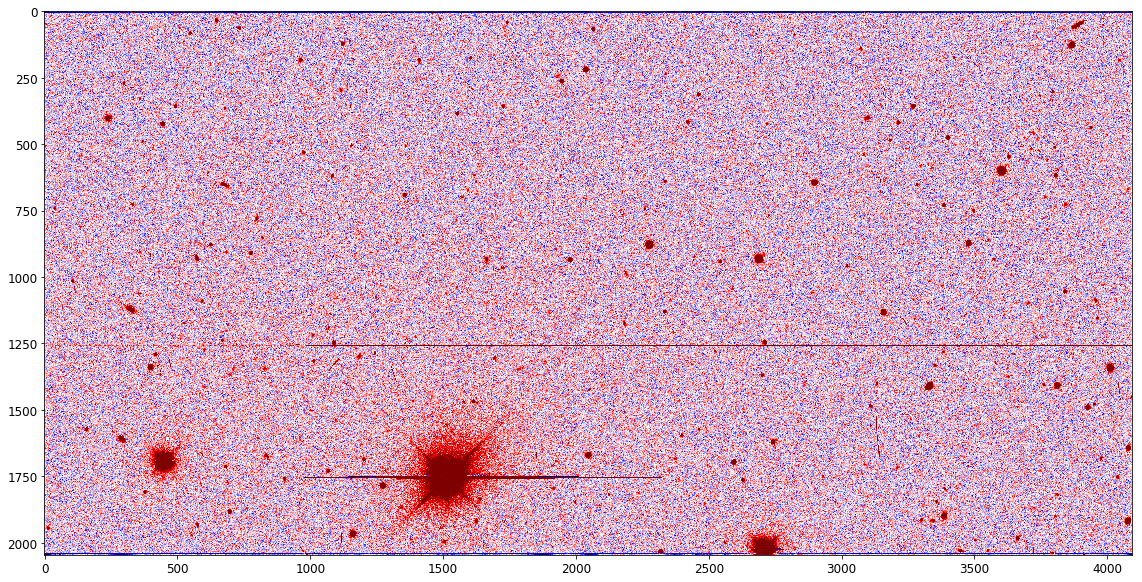

---------


In [83]:
band = 'g'

# vrange = vranges[band]
vrange = 0.03

mask = ccd0['filter']==band
ccd1 = ccd0[mask]

# for ccd1_index in range(len(ccd1)):
# for ccd1_index in [0]:

expnum_halo = '535126'

for ccd1_index in range(len(ccd1)):
    
    if not (expnum_halo in str(ccd1['expnum'][ccd1_index])):
        continue
    
    expnum_str = str(ccd1['expnum'][ccd1_index])
    print(expnum_str)
    ccdname = ccd1['ccdname'][ccd1_index]
    if 'S7' in ccdname:
        continue

    fn_prefix = ccd1['camera'][ccd1_index]+'-'+(5-len(expnum_str[:3]))*'0'+expnum_str+'-'+ccdname
    # print(fn_prefix)
    # print('seeing = {:.2f} arcsec'.format(ccd1['seeing'][ccd1_index]))
    # print('airmass = {:.2f}'.format(ccd1['airmass'][ccd1_index]))

    ########## Outer PSF parameters ###########
    if band=='z' and (ccdname in outlier_ccd_list):
        params_to_use = params_outlier
    else:
        params_to_use = params

    if band!='z':
        plexp2, weight2 = params_to_use[band+'_plexp2'], params_to_use[band+'_weight2']
    else:
        alpha2, beta2, weight2 = params_to_use[band+'_alpha2'], params_to_use[band+'_beta2'],  params_to_use[band+'_weight2']

    #####################################################################################

    image_dir = '/global/project/projectdirs/cosmo/staging/'
    fn = os.path.join(image_dir, ccd1['image_filename'][ccd1_index]).rstrip()
    # print(fn)

    hdulist = fits.open(fn)
    # print(hdu[ccd1['image_hdu'][ccd1_index]].header)
    img_raw = hdulist[ccd1['image_hdu'][ccd1_index]].data

    # naive sky subtraction
    mask = (img_raw<np.percentile(img_raw.flatten(), 85))
    img = img_raw - np.median(img_raw[mask].flatten())
    norm_factor0 = 10**((ccd1['ccdzpt'][ccd1_index]-22.5)/2.5) * ccd1['exptime'][ccd1_index]
    # convert to nanomaggie per pixel
    img = img / norm_factor0

    xgrid = pixscale * np.linspace(-0.5*(img.shape[1]-1), 0.5*(img.shape[1]-1), img.shape[1])
    ygrid = pixscale * np.linspace(-0.5*(img.shape[0]-1), 0.5*(img.shape[0]-1), img.shape[0])
    xx, yy = np.meshgrid(xgrid, ygrid)

    # astrometric correction
    ccdraoff, ccddecoff = -ccd1['ccdraoff'][ccd1_index], -ccd1['ccddecoff'][ccd1_index]

    w = wcs.WCS(hdulist[ccd1['image_hdu'][ccd1_index]].header)
    xpixcenter, ypixcenter = w.wcs_world2pix([[ra, dec]], True)[0]
    if (xpixcenter<0) or (ypixcenter<0) or (xpixcenter>img.shape[1]) or (ypixcenter>img.shape[0]):
        raise ValueError ('outside the CCD!!!')
        # print('outside the CCD!!!')
        # continue

    print('Exposure: {}  CCD: {}'.format(expnum_str, ccdname))

    ccddecoff += pixscale*(xpixcenter-(img.shape[1]/2+0.5))
    ccdraoff += pixscale*(ypixcenter-(img.shape[0]/2+0.5))

    xx, yy = xx - ccddecoff, yy - ccdraoff

    radius_grid = np.sqrt(xx**2 + yy**2)
    radius = radius_grid.flatten()
    radius_plot = np.logspace(-1, 3, 1000)
    flux = img.flatten()

    ######################################################################

    # normalization of a 22.5 magnitude star
    norm_factor =  10**((ls_mag[band]-22.5)/2.5)

    if band!='z':
        img_predict = pixscale**2 * weight2 * radius_grid**(plexp2) / norm_factor
        flux_plot2 = weight2 * pixscale**2 * radius_plot**(plexp2)
    else:
        img_predict = pixscale**2 * weight2 * get_sb_moffat(radius_grid, alpha2, beta2) / norm_factor
        flux_plot2 = weight2 * pixscale**2 * get_sb_moffat(radius_plot, alpha2, beta2)

    mask = radius_grid>180
    img_predict[mask] = 0
        
    # # trim edges to enable downsizing
    # # trimmed image size need to be multiples of binsize
    # trim_size_x, trim_size_y = 1, 1
    # img = img[trim_size_y:(img.shape[0]-trim_size_y), trim_size_x:(img.shape[1]-trim_size_x)]
    # img_predict = img_predict[trim_size_y:(img_predict.shape[0]-trim_size_y), trim_size_x:(img_predict.shape[1]-trim_size_x)]

    # binsize = 4
    # img = np.mean(np.mean(img.reshape((img.shape[0]//binsize, binsize, img.shape[1]//binsize,-1)), axis=3), axis=1)
    # img_predict = np.mean(np.mean(img_predict.reshape((img_predict.shape[0]//binsize, binsize, img_predict.shape[1]//binsize,-1)), axis=3), axis=1)

    plt.figure(figsize=(20, 10))
    plt.imshow(np.flip((img).T, axis=1), cmap='seismic', vmin=-vrange, vmax=vrange)
    plt.show()
    
    plt.figure(figsize=(20, 10))
    plt.imshow(np.flip((img-img_predict).T, axis=1), cmap='seismic', vmin=-vrange, vmax=vrange)
    plt.show()
    
    print('---------')

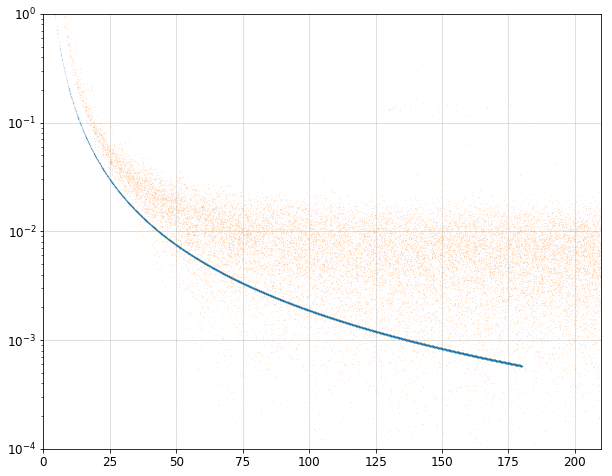

In [84]:
plt.figure(figsize=(10, 8))
plt.plot(radius[::50], img_predict.flatten()[::50], '.', ms=0.1)
plt.plot(radius[::50], img.flatten()[::50], '.', ms=0.1)
plt.yscale('log')
plt.xlim(0, 210)
plt.ylim(1e-4, 1e0)
plt.grid(alpha=0.5)
plt.show()

## No normalization

535126
decam-00535126-S14
1755.10696116 2577.7058778
290.893038842 1516.2941222
Exposure: 535126  CCD: S14


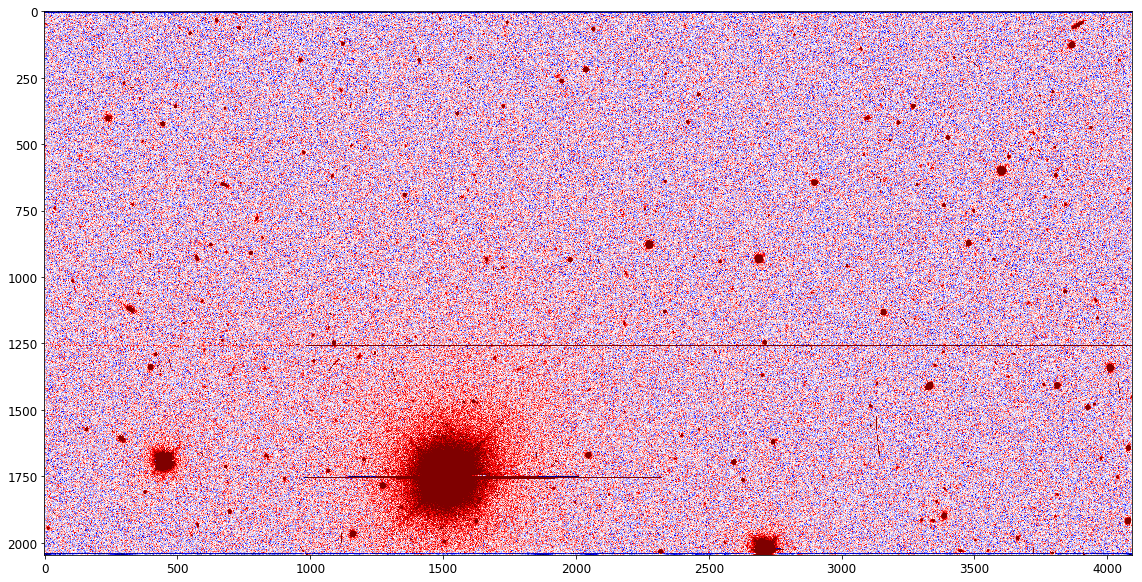

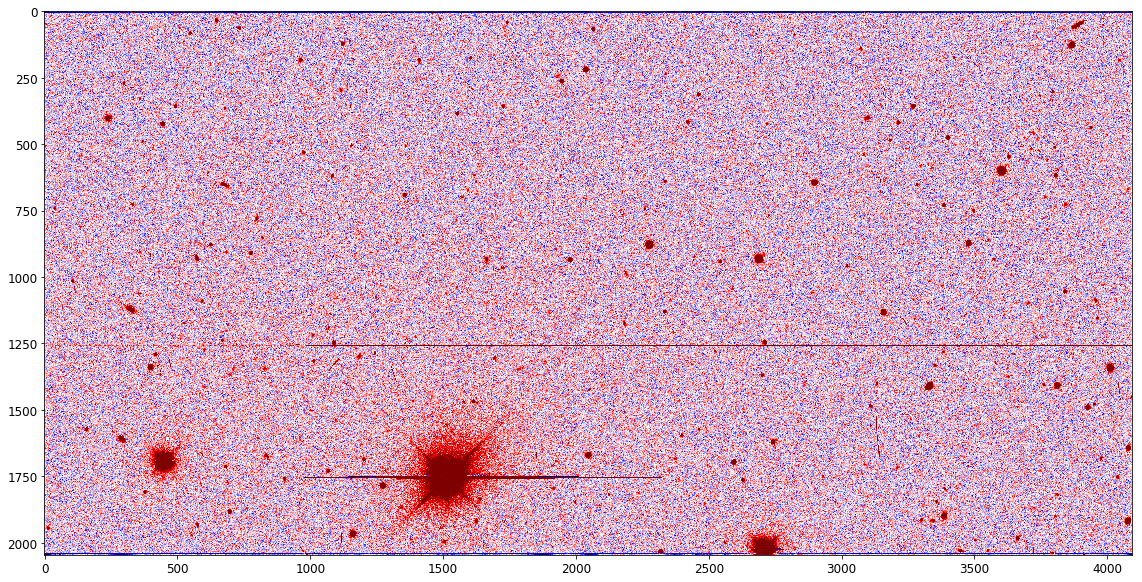

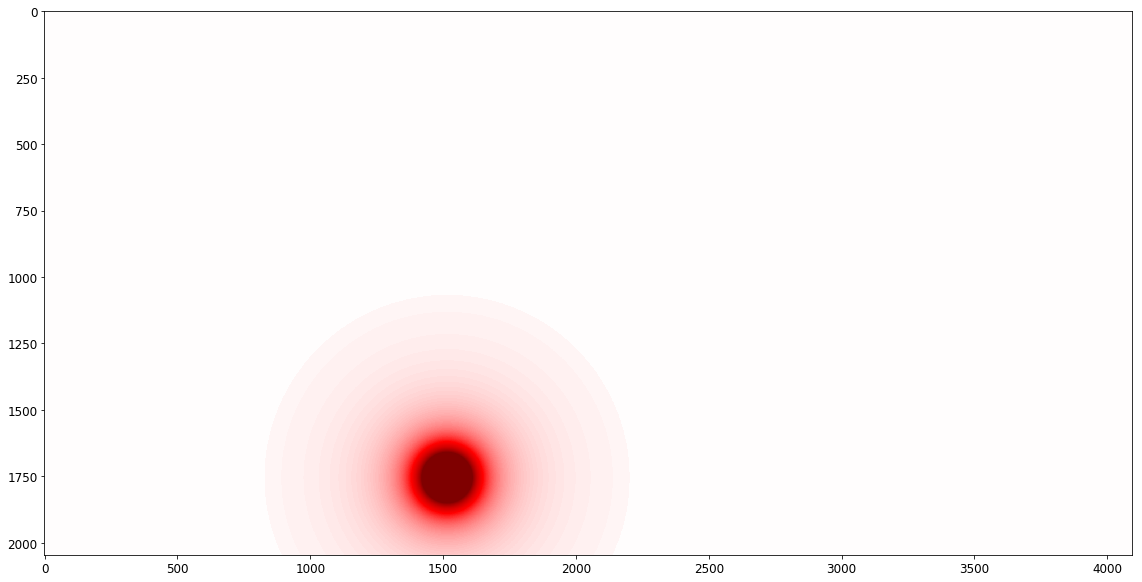

---------


In [85]:
band = 'g'

# vrange = vranges[band]
vrange = 0.03

mask = ccd0['filter']==band
ccd1 = ccd0[mask]

# for ccd1_index in range(len(ccd1)):
# for ccd1_index in [0]:

expnum_halo = '535126'

for ccd1_index in range(len(ccd1)):
    
    if not (expnum_halo in str(ccd1['expnum'][ccd1_index])):
        continue
    
    expnum_str = str(ccd1['expnum'][ccd1_index])
    print(expnum_str)
    ccdname = ccd1['ccdname'][ccd1_index]
    if 'S7' in ccdname:
        continue

    fn_prefix = ccd1['camera'][ccd1_index]+'-'+(5-len(expnum_str[:3]))*'0'+expnum_str+'-'+ccdname
    print(fn_prefix)
    # print(fn_prefix)
    # print('seeing = {:.2f} arcsec'.format(ccd1['seeing'][ccd1_index]))
    # print('airmass = {:.2f}'.format(ccd1['airmass'][ccd1_index]))

    ########## Outer PSF parameters ###########
    if band=='z' and (ccdname in outlier_ccd_list):
        params_to_use = params_outlier
    else:
        params_to_use = params

    if band!='z':
        plexp2, weight2 = params_to_use[band+'_plexp2'], params_to_use[band+'_weight2']
    else:
        alpha2, beta2, weight2 = params_to_use[band+'_alpha2'], params_to_use[band+'_beta2'],  params_to_use[band+'_weight2']

    #####################################################################################

    image_dir = '/global/project/projectdirs/cosmo/staging/'
    fn = os.path.join(image_dir, ccd1['image_filename'][ccd1_index]).rstrip()
    # print(fn)

    hdulist = fits.open(fn)
    # print(hdu[ccd1['image_hdu'][ccd1_index]].header)
    img_raw = hdulist[ccd1['image_hdu'][ccd1_index]].data

    # naive sky subtraction
    mask = (img_raw<np.percentile(img_raw.flatten(), 85))
    img = img_raw - np.median(img_raw[mask].flatten())
    
    norm_factor0 = 10**((ccd1['ccdzpt'][ccd1_index]-22.5)/2.5) * ccd1['exptime'][ccd1_index]
    # # convert to nanomaggie per pixel
    # img = img / norm_factor0
    vrange = vrange * norm_factor0

    xgrid = pixscale * np.linspace(-0.5*(img.shape[1]-1), 0.5*(img.shape[1]-1), img.shape[1])
    ygrid = pixscale * np.linspace(-0.5*(img.shape[0]-1), 0.5*(img.shape[0]-1), img.shape[0])
    xx, yy = np.meshgrid(xgrid, ygrid)

    # astrometric correction
    ccdraoff, ccddecoff = -ccd1['ccdraoff'][ccd1_index], -ccd1['ccddecoff'][ccd1_index]

    w = wcs.WCS(hdulist[ccd1['image_hdu'][ccd1_index]].header)
    xpixcenter, ypixcenter = w.wcs_world2pix([[ra, dec]], True)[0]
    print(xpixcenter, ypixcenter)
    print(img.shape[1]-xpixcenter, img.shape[0]-ypixcenter)
    if (xpixcenter<0) or (ypixcenter<0) or (xpixcenter>img.shape[1]) or (ypixcenter>img.shape[0]):
        raise ValueError ('outside the CCD!!!')
        # print('outside the CCD!!!')
        # continue

    print('Exposure: {}  CCD: {}'.format(expnum_str, ccdname))

    ccddecoff += pixscale*(xpixcenter-(img.shape[1]/2+0.5))
    ccdraoff += pixscale*(ypixcenter-(img.shape[0]/2+0.5))

    xx, yy = xx - ccddecoff, yy - ccdraoff

    radius_grid = np.sqrt(xx**2 + yy**2)
    radius = radius_grid.flatten()
    radius_plot = np.logspace(-1, 3, 1000)
    flux = img.flatten()

    ######################################################################

    # normalization of a 22.5 magnitude star
    norm_factor = 10**((ls_mag[band]-22.5)/2.5)
    norm_factor = norm_factor / norm_factor0

    if band!='z':
        img_predict = pixscale**2 * weight2 * radius_grid**(plexp2) / norm_factor
        flux_plot2 = weight2 * pixscale**2 * radius_plot**(plexp2)
    else:
        img_predict = pixscale**2 * weight2 * get_sb_moffat(radius_grid, alpha2, beta2) / norm_factor
        flux_plot2 = weight2 * pixscale**2 * get_sb_moffat(radius_plot, alpha2, beta2)

    mask = radius_grid>180
    img_predict[mask] = 0
        
    # # trim edges to enable downsizing
    # # trimmed image size need to be multiples of binsize
    # trim_size_x, trim_size_y = 1, 1
    # img = img[trim_size_y:(img.shape[0]-trim_size_y), trim_size_x:(img.shape[1]-trim_size_x)]
    # img_predict = img_predict[trim_size_y:(img_predict.shape[0]-trim_size_y), trim_size_x:(img_predict.shape[1]-trim_size_x)]

    # binsize = 4
    # img = np.mean(np.mean(img.reshape((img.shape[0]//binsize, binsize, img.shape[1]//binsize,-1)), axis=3), axis=1)
    # img_predict = np.mean(np.mean(img_predict.reshape((img_predict.shape[0]//binsize, binsize, img_predict.shape[1]//binsize,-1)), axis=3), axis=1)

    plt.figure(figsize=(20, 10))
    plt.imshow(np.flip((img).T, axis=1), cmap='seismic', vmin=-vrange, vmax=vrange)
    plt.show()
    
    plt.figure(figsize=(20, 10))
    plt.imshow(np.flip((img-img_predict).T, axis=1), cmap='seismic', vmin=-vrange, vmax=vrange)
    plt.show()
    
    plt.figure(figsize=(20, 10))
    plt.imshow(np.flip((img_predict).T, axis=1), cmap='seismic', vmin=-vrange, vmax=vrange)
    plt.show()

    print('---------')

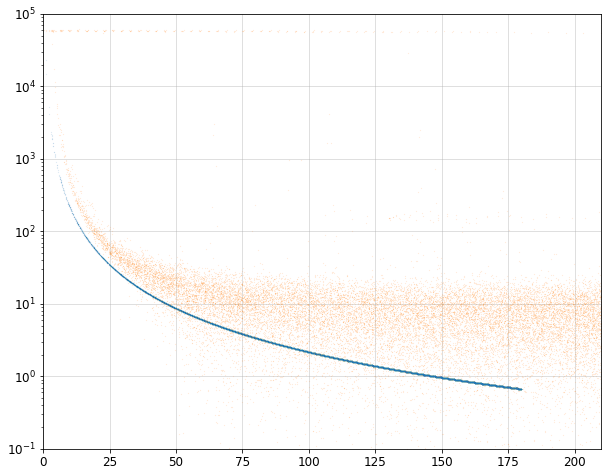

In [86]:
plt.figure(figsize=(10, 8))
plt.plot(radius[::50], img_predict.flatten()[::50], '.', ms=0.1)
plt.plot(radius[::50], img.flatten()[::50], '.', ms=0.1)
plt.yscale('log')
plt.xlim(0, 210)
plt.ylim(1e-1, 1e5)
plt.grid(alpha=0.5)
plt.show()

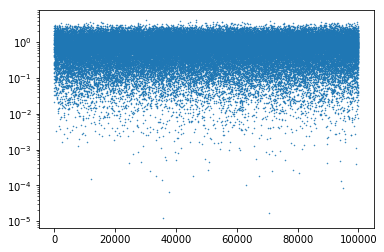

In [8]:
a = np.random.randn(int(1e5))
plt.plot(a, '.', ms=1)
plt.yscale('log')
plt.show()